### Чтение шрифтов из папки fonts

In [1]:
import os

def find_fonts(folder_path):
    font_paths = []

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.ttf', '.otf')):
                font_paths.append(os.path.join(root, file))

    return font_paths


folder_path = 'fonts'
font_paths = find_fonts(folder_path)

print(font_paths)


['fonts/Aguante/Aguante-Regular.otf', 'fonts/Ghastly Panic/GhastlyPanicCyr.otf', 'fonts/Brass Mono/BrassMono-Regular.ttf', 'fonts/Brass Mono/BrassMono-Italic.ttf', 'fonts/Brass Mono/BrassMono-BoldItalic.ttf', 'fonts/Brass Mono/BrassMono-Bold.ttf', 'fonts/Better VCR/better-vcr-5.2.ttf', 'fonts/Sans Collegiate One/AlumniSansCollegiateOne-Italic.ttf', 'fonts/Sans Collegiate One/AlumniSansCollegiateOne-Regular.ttf', 'fonts/Ganesha Type/GaneshaType-Regular.ttf', 'fonts/Tana Uncial SP/TanaUncialSP.otf', 'fonts/Realest/Realest-Extended.otf', 'fonts/Aref Ruqaa Ink/ArefRuqaaInk-Regular.ttf', 'fonts/Aref Ruqaa Ink/ArefRuqaaInk-Bold.ttf', 'fonts/Ambidexter/ambidexter_regular.otf']


In [2]:
print(len(font_paths))

15


In [3]:
mapping = {index: value for index, value in enumerate(font_paths)}

print(mapping)

{0: 'fonts/Aguante/Aguante-Regular.otf', 1: 'fonts/Ghastly Panic/GhastlyPanicCyr.otf', 2: 'fonts/Brass Mono/BrassMono-Regular.ttf', 3: 'fonts/Brass Mono/BrassMono-Italic.ttf', 4: 'fonts/Brass Mono/BrassMono-BoldItalic.ttf', 5: 'fonts/Brass Mono/BrassMono-Bold.ttf', 6: 'fonts/Better VCR/better-vcr-5.2.ttf', 7: 'fonts/Sans Collegiate One/AlumniSansCollegiateOne-Italic.ttf', 8: 'fonts/Sans Collegiate One/AlumniSansCollegiateOne-Regular.ttf', 9: 'fonts/Ganesha Type/GaneshaType-Regular.ttf', 10: 'fonts/Tana Uncial SP/TanaUncialSP.otf', 11: 'fonts/Realest/Realest-Extended.otf', 12: 'fonts/Aref Ruqaa Ink/ArefRuqaaInk-Regular.ttf', 13: 'fonts/Aref Ruqaa Ink/ArefRuqaaInk-Bold.ttf', 14: 'fonts/Ambidexter/ambidexter_regular.otf'}


### Генерация обучающей и тестовой выборки на основании шрифтов

In [4]:
#!pip install pillow

In [5]:
from PIL import Image, ImageDraw, ImageFont
import random
import os

# Определение путей для сохранения наборов данных
train_path = 'train_data'
test_path = 'test_data'

# Создание папок для обучающего и тестового наборов данных
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Определение списка символов английского алфавита
characters = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

# Функция для создания изображения с текстом и указанным шрифтом с аугментацией
def create_augmented_image(font_path, text, image_size=(200, 100), text_position=(10, 10), font_size=50):
    image = Image.new('RGB', image_size, 'white')
    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype(font_path, font_size)

    # Введение случайного поворота
    rotation_angle = random.uniform(-10, 10)
    rotated_image = image.rotate(rotation_angle, resample=Image.BICUBIC, expand=True)

    # Введение случайного смещения
    x_offset = random.randint(-5, 5)
    y_offset = random.randint(-5, 5)
    translated_image = Image.new('RGB', image_size, 'white')
    translated_image.paste(rotated_image, (x_offset, y_offset))

    # Применение текста
    draw = ImageDraw.Draw(translated_image)
    draw.text(text_position, text, font=font, fill='black')

    return translated_image

# Класс для каждого шрифта с аугментацией
class AugmentedFontDataset:
    def __init__(self, font_path):
        self.font_path = font_path
        self.train_path = os.path.join(train_path, os.path.basename(font_path).replace(' ', '_').replace('/', '_'))
        self.test_path = os.path.join(test_path, os.path.basename(font_path).replace(' ', '_').replace('/', '_'))
        os.makedirs(self.train_path, exist_ok=True)
        os.makedirs(self.test_path, exist_ok=True)

    def generate_dataset(self, num_samples=100, train_ratio=0.8):
        num_train_samples = int(num_samples * train_ratio)
        num_test_samples = num_samples - num_train_samples

        train_counter, test_counter = 0, 0

        for _ in range(num_samples):
            # Определение, добавлять в обучающий или тестовый набор данных
            if train_counter < num_train_samples:
                dataset_path = self.train_path
                train_counter += 1
            else:
                dataset_path = self.test_path
                test_counter += 1

            # Генерация случайного текста
            text_length = random.randint(1, 5)
            text = ''.join(random.choice(characters) for _ in range(text_length))

            # Создание аугментированного изображения с указанным шрифтом и сохранение
            augmented_image = create_augmented_image(self.font_path, text)
            image_name = f"{text}_{os.path.basename(self.font_path).replace(' ', '_').replace('/', '_')}.png"
            augmented_image.save(os.path.join(dataset_path, image_name))

# Создание объектов AugmentedFontDataset и генерация наборов данных
for font_path in font_paths:
    augmented_font_dataset = AugmentedFontDataset(font_path)
    augmented_font_dataset.generate_dataset(num_samples=100, train_ratio=0.8)


### Модуль обучения

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import os
import csv

#параметры нейросети (можно захардкодить или передавать извне)
input_shape = (200, 100, 3)
num_classes = 15
epochs = 10
batch_size = 32

#создание нейросети
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

#компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#загрузка данных
train_data_dir = 'train_data'
test_data_dir = 'test_data'

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

#обучение нейросети
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

#логгирование ошибок
log_file = 'training_log.csv'

with open(log_file, 'w', newline='') as csvfile:
    fieldnames = ['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    for epoch in range(epochs):
        writer.writerow({
            'epoch': epoch + 1,
            'train_loss': history.history['loss'][epoch],
            'train_accuracy': history.history['accuracy'][epoch],
            'val_loss': history.history['val_loss'][epoch],
            'val_accuracy': history.history['val_accuracy'][epoch]
        })

2024-02-05 16:53:24.896307: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-05 16:53:28.461782: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 1137 images belonging to 15 classes.
Found 296 images belonging to 15 classes.
Epoch 1/10
35/35 [==============================] - 12s 326ms/step - loss: 11.4585 - accuracy: 0.1747 - val_loss: 1.7613 - val_accuracy: 0.4688
Epoch 2/10
35/35 [==============================] - 11s 305ms/step - loss: 0.8924 - accuracy: 0.7575 - val_loss: 0.7252 - val_accuracy: 0.7708
Epoch 3/10
35/35 [==============================] - 11s 317ms/step - loss: 0.3195 - accuracy: 0.9303 - val_loss: 0.5055 - val_accuracy: 0.8403
Epoch 4/10
35/35 [==============================] - 12s 332ms/step - loss: 0.1395 - accuracy: 0.9783 - val_loss: 0.4498 - val_accuracy: 0.8576
Epoch 5/10
35/35 [==============================] - 11s 307ms/step - loss: 0.0724 - accuracy: 0.9955 - val_loss: 0.3809 - val_accuracy: 0.8750
Epoch 6/10
35/35 [==============================] - 10s 294ms/step - loss: 0.0359 - accuracy: 1.0000 - val_loss: 0.3900 - val_accuracy: 0.8646
Epoch 7/10
35/35 [==============================] - 10s 

### Оценка основных метрик классификации

In [7]:
print("Версия TensorFlow:", tf.__version__)

Версия TensorFlow: 2.11.0


В 2.15.0 есть tf.keras.metrics.F1Score (https://www.tensorflow.org/api_docs/python/tf/keras/metrics/F1Score)

Precision: 0.89045936
Recall: 0.8513514
Аccuracy: 0.8648649
F1-Score: 0.8644847790329433


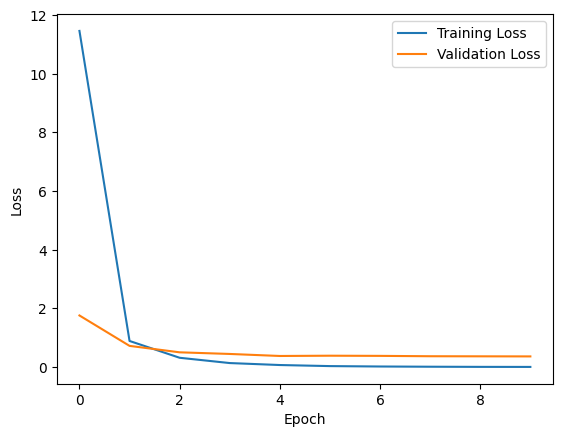

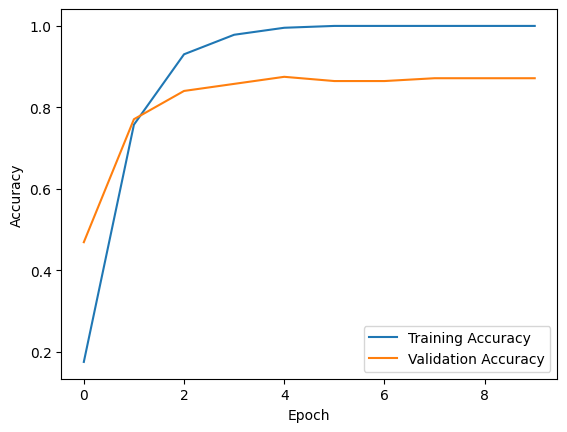

In [8]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt

# Создать экземпляры метрик
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
accuracy = tf.keras.metrics.Accuracy()

# Оценка на тестовых данных
test_steps = test_generator.samples // batch_size + 1
true_labels = []
predicted_labels = []

for _ in range(test_steps):
    batch_data, batch_labels = test_generator.next()
    predictions = model.predict_on_batch(batch_data)
    
    precision.update_state(batch_labels, predictions)
    recall.update_state(batch_labels, predictions)
    accuracy.update_state(tf.argmax(batch_labels, axis=1), tf.argmax(predictions, axis=1))

    true_labels.extend(np.argmax(batch_labels, axis=1))
    predicted_labels.extend(np.argmax(predictions, axis=1))

# Получение значения метрик
precision_result = precision.result().numpy()
recall_result = recall.result().numpy()
accuracy_result = accuracy.result().numpy()
f1score_result = f1_score(true_labels, predicted_labels, average='weighted')

print("Precision:", precision_result)
print("Recall:", recall_result)
print("Аccuracy:", accuracy_result)
print("F1-Score:", f1score_result)

# Отрисовка кривых обучения и тестирования
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [11]:
class_names = list(train_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

print("Confusion Matrix:")
print(confusion_matrix(true_labels, predicted_labels))

Classification Report:
                                     precision    recall  f1-score   support

                Aguante-Regular.otf       1.00      0.95      0.97        19
 AlumniSansCollegiateOne-Italic.ttf       0.75      0.75      0.75        20
AlumniSansCollegiateOne-Regular.ttf       0.76      0.65      0.70        20
              ArefRuqaaInk-Bold.ttf       0.81      0.85      0.83        20
           ArefRuqaaInk-Regular.ttf       0.84      0.80      0.82        20
                 BrassMono-Bold.ttf       0.82      0.90      0.86        20
           BrassMono-BoldItalic.ttf       0.88      0.75      0.81        20
               BrassMono-Italic.ttf       0.73      0.95      0.83        20
              BrassMono-Regular.ttf       0.88      0.79      0.83        19
            GaneshaType-Regular.ttf       1.00      0.85      0.92        20
                GhastlyPanicCyr.otf       0.80      1.00      0.89        20
               Realest-Extended.otf       1.00      

In [12]:
print(class_names)

['Aguante-Regular.otf', 'AlumniSansCollegiateOne-Italic.ttf', 'AlumniSansCollegiateOne-Regular.ttf', 'ArefRuqaaInk-Bold.ttf', 'ArefRuqaaInk-Regular.ttf', 'BrassMono-Bold.ttf', 'BrassMono-BoldItalic.ttf', 'BrassMono-Italic.ttf', 'BrassMono-Regular.ttf', 'GaneshaType-Regular.ttf', 'GhastlyPanicCyr.otf', 'Realest-Extended.otf', 'TanaUncialSP.otf', 'ambidexter_regular.otf', 'better-vcr-5.2.ttf']


### Сохранение чекпойнта модели

In [10]:
model.save('font_model.h5')

# Консольное приложение 

> pip install virtualenv

> virtualenv venv

> source venv/bin/activate

> pip install tensorflow numpy

> pip install Pillow

> python3 font.py font_model.h5 test.png

> deactivate